# XGBoost

## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xg 
from xgboost import plot_importance
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import optuna

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the RMSLE function
The RMSLE is the measure of error used in the Kaggle competition to evaluate the predictions, the goal is to reduce as much as possible the RMSLE when training the XGBoost model

In [2]:
def rmsle(y_true, y_pred):
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)
    squared_diff = (log_y_true - log_y_pred) ** 2
    mean_squared_error = np.mean(squared_diff)
    rmsle_val = np.sqrt(mean_squared_error)
    return rmsle_val


### Define function to retrieve complete hyperparameters

In [3]:
def getHyperparameters(optuna_params): 
    missing_params = {"objective": "reg:squaredlogerror","n_estimators": 1000, "verbosity": 0,"eval_metric":"rmsle"}
    model_params = optuna_params
    for keys in missing_params.keys():
        model_params[keys] = missing_params[keys]
        
    return model_params        

## Label Encoding Model

### Read train and validation data with week 8 as validation

In [20]:
def getTrainData(path = 'data/train_aguascalientes.csv', week = 8):
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    X_train = df.drop(['Demanda_uni_equil', 'CategoriaProducto'], axis=1).query(f'Semana < 8')
    y_train = df[['Demanda_uni_equil', 'Semana']].query(f'Semana < 8')
    X_validate = df.drop(['Demanda_uni_equil', 'CategoriaProducto'], axis=1).query(f'Semana == {week}')
    y_validate = df[['Demanda_uni_equil', 'Semana']].query(f'Semana == {week}')
            
    return X_train, y_train, X_validate, y_validate

### Get train data for the model
Use data from week 3 to 7 for training an setting the week 8 and 9 for validation 

In [21]:
X_train, y_train, X_validate, y_validate = getTrainData()

### XGBoost model with standard parameters

In [43]:
basic_model = xg.XGBRegressor()
basic_model.fit(X_train, y_train['Demanda_uni_equil'], verbose=False)
basic_model_predictions = basic_model.predict(X_validate)

In [44]:
rmsle(y_validate['Demanda_uni_equil'], basic_model_predictions)

C:\Users\buga_\AppData\Local\Temp\ipykernel_24300\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)


0.04981518831476527

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

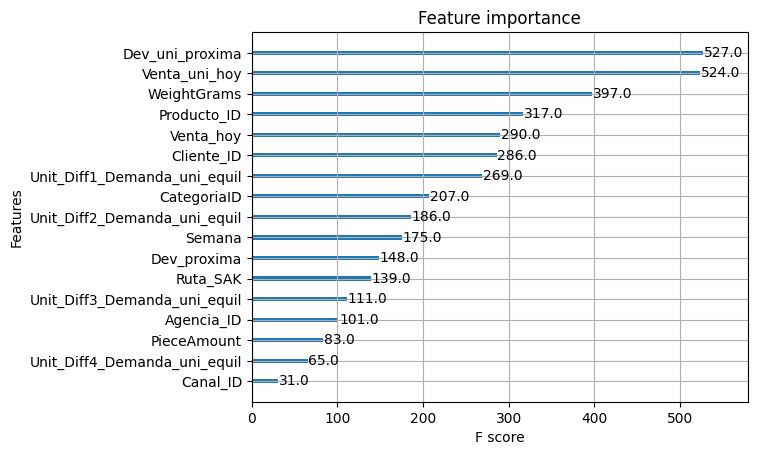

In [46]:
plot_importance(basic_model)

### Hyperparameter tuning employing Bayesian Optimization with Optuna
To improve the model generated by the XGBoost library with its improve standard parameters. A hyperparameter tuning will be performed to improve the model. After contemplating the implementation of Grid Search, Random Search and Bayesian Optimization as tuning methods, it was decided to implement this last one. Bayesian Optimization allows to search the best parameters of the model considering the time constraint and computational power required by the Grid Search method, while keeping the precision of the parameter searching by taking into account historic values of previous tuning, in contrast to Random Search. 


#### Model's function for RMSLE minimization

In [11]:
# Definition of the model and parameters that will be considered by the Optuna library for tuning
def objective(trial):
    params = {
        "objective": "reg:squaredlogerror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "eval_metric":"rmsle"
    }

    model = xg.XGBRegressor(**params)
    model.fit(X_train, y_train['Demanda_uni_equil'], verbose=False)
    predictions = model.predict(X_validate)
    print(predictions)
    rmsle_val = rmsle(y_validate['Demanda_uni_equil'], predictions)
    return rmsle_val

#### Hyperparameter tuning with 50 trials

In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-12-02 02:03:50,361] A new study created in memory with name: no-name-ab2679b9-13b9-4e09-bcad-e9957aa76a83
[I 2023-12-02 02:06:06,955] Trial 0 finished with value: 0.04703139989462164 and parameters: {'learning_rate': 0.031158889178640348, 'max_depth': 8, 'subsample': 0.8554140168988082, 'colsample_bytree': 0.7311500426062529, 'min_child_weight': 1}. Best is trial 0 with value: 0.04703139989462164.


[  9.065998 119.727135  24.086348 ... 125.385925 122.89622  122.55447 ]


[I 2023-12-02 02:08:00,615] Trial 1 finished with value: 0.09193069584445078 and parameters: {'learning_rate': 0.030487183593640298, 'max_depth': 4, 'subsample': 0.35771091078737033, 'colsample_bytree': 0.984708634176383, 'min_child_weight': 10}. Best is trial 0 with value: 0.04703139989462164.


[ 8.986532 62.87561  27.402908 ... 63.01402  62.906654 62.906654]


[I 2023-12-02 02:10:24,130] Trial 2 finished with value: 0.09543749210504118 and parameters: {'learning_rate': 0.010344696007497711, 'max_depth': 8, 'subsample': 0.5530909014428855, 'colsample_bytree': 0.9012899547401325, 'min_child_weight': 17}. Best is trial 0 with value: 0.04703139989462164.


[ 9.090972 58.25469  24.851217 ... 58.114086 58.28578  58.28578 ]


[I 2023-12-02 02:12:03,221] Trial 3 finished with value: 0.15328966732168747 and parameters: {'learning_rate': 0.020932734451221933, 'max_depth': 1, 'subsample': 0.5866153164911502, 'colsample_bytree': 0.5091210177310711, 'min_child_weight': 10}. Best is trial 0 with value: 0.04703139989462164.


[ 9.404879 61.688286 24.988924 ... 55.78019  54.895008 54.890804]


[I 2023-12-02 02:14:41,325] Trial 4 finished with value: 0.9278019702174469 and parameters: {'learning_rate': 0.0012038751416205233, 'max_depth': 9, 'subsample': 0.7129203730344553, 'colsample_bytree': 0.6959327928051384, 'min_child_weight': 2}. Best is trial 0 with value: 0.04703139989462164.


[2.2587714 3.18997   2.6091654 ... 3.1719217 3.1136048 3.1019068]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:16:52,336] Trial 5 finished with value: 0.0803260957758959 and parameters: {'learning_rate': 0.058217596671907866, 'max_depth': 8, 'subsample': 0.9858469646539184, 'colsample_bytree': 0.5530294651960985, 'min_child_weight': 13}. Best is trial 0 with value: 0.04703139989462164.


[ 9.130988 81.3562   22.27842  ... 80.487495 79.67887  79.71769 ]


[I 2023-12-02 02:19:25,300] Trial 6 finished with value: 0.8822916705099566 and parameters: {'learning_rate': 0.0013545770358269183, 'max_depth': 8, 'subsample': 0.6913222818110212, 'colsample_bytree': 0.5421056572455162, 'min_child_weight': 13}. Best is trial 0 with value: 0.04703139989462164.


[2.4718606 3.637956  2.8414283 ... 3.6089118 3.5148628 3.5027122]


[I 2023-12-02 02:21:09,081] Trial 7 finished with value: 0.5468935761188717 and parameters: {'learning_rate': 0.0036827053533987375, 'max_depth': 1, 'subsample': 0.39410470493510036, 'colsample_bytree': 0.49972504611943175, 'min_child_weight': 11}. Best is trial 0 with value: 0.04703139989462164.


[6.4571185 8.034797  7.0339694 ... 7.1032987 6.8227696 6.8227696]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:23:43,303] Trial 8 finished with value: 0.13928780548694797 and parameters: {'learning_rate': 0.024397875669421015, 'max_depth': 9, 'subsample': 0.22655588128273085, 'colsample_bytree': 0.23107523743350983, 'min_child_weight': 16}. Best is trial 0 with value: 0.04703139989462164.


[ 8.569789 50.93471  30.012737 ... 48.33607  46.753124 46.24439 ]


[I 2023-12-02 02:26:32,204] Trial 9 finished with value: 0.5339055326669504 and parameters: {'learning_rate': 0.0026370596854375927, 'max_depth': 10, 'subsample': 0.3642010538728072, 'colsample_bytree': 0.5153573053066433, 'min_child_weight': 4}. Best is trial 0 with value: 0.04703139989462164.


[4.628723  9.727691  6.3930006 ... 9.600626  8.986534  8.964054 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:28:29,147] Trial 10 finished with value: 0.17757445488217927 and parameters: {'learning_rate': 0.09124147907181115, 'max_depth': 5, 'subsample': 0.06884290501837109, 'colsample_bytree': 0.06247431402056941, 'min_child_weight': 6}. Best is trial 0 with value: 0.04703139989462164.


[ 8.858952 48.37319  31.944834 ... 43.500168 39.664463 39.355804]


[I 2023-12-02 02:30:32,963] Trial 11 finished with value: 0.0823236994273658 and parameters: {'learning_rate': 0.08138514903767761, 'max_depth': 7, 'subsample': 0.9548668512079935, 'colsample_bytree': 0.777493248017866, 'min_child_weight': 20}. Best is trial 0 with value: 0.04703139989462164.


[ 9.150435 73.4398   20.952765 ... 71.925125 74.47853  74.47077 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:32:34,082] Trial 12 finished with value: 0.06064208301764333 and parameters: {'learning_rate': 0.047891386026377374, 'max_depth': 6, 'subsample': 0.9972797426046263, 'colsample_bytree': 0.7383691813072621, 'min_child_weight': 7}. Best is trial 0 with value: 0.04703139989462164.


[ 9.194446 92.00786  22.71196  ... 90.38209  89.55366  88.661766]


[I 2023-12-02 02:34:39,698] Trial 13 finished with value: 0.04779224271287655 and parameters: {'learning_rate': 0.03075562260428331, 'max_depth': 6, 'subsample': 0.86159511734594, 'colsample_bytree': 0.7570820935650988, 'min_child_weight': 1}. Best is trial 0 with value: 0.04703139989462164.


[  9.224461 117.517715  24.082043 ... 125.20532  122.63069  122.429115]


[I 2023-12-02 02:36:32,249] Trial 14 finished with value: 0.07294644327449004 and parameters: {'learning_rate': 0.014037272710037732, 'max_depth': 3, 'subsample': 0.83563379627631, 'colsample_bytree': 0.8463872720623685, 'min_child_weight': 1}. Best is trial 0 with value: 0.04703139989462164.


[  8.94338  107.96422   23.869453 ... 112.12927  111.1467   109.89086 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:38:37,407] Trial 15 finished with value: 0.05974642484533449 and parameters: {'learning_rate': 0.03973323166677561, 'max_depth': 6, 'subsample': 0.8276868262900767, 'colsample_bytree': 0.6509430499887903, 'min_child_weight': 4}. Best is trial 0 with value: 0.04703139989462164.


[ 9.314657 93.603134 23.403015 ... 95.64928  93.094505 92.429726]


[I 2023-12-02 02:40:28,419] Trial 16 finished with value: 0.06841442819015882 and parameters: {'learning_rate': 0.016760553098814766, 'max_depth': 3, 'subsample': 0.8540736302118163, 'colsample_bytree': 0.8595990157078379, 'min_child_weight': 1}. Best is trial 0 with value: 0.04703139989462164.


[  9.069777 110.02018   23.446066 ... 112.613144 110.35676  109.98854 ]


[I 2023-12-02 02:42:28,057] Trial 17 finished with value: 0.06454508950296296 and parameters: {'learning_rate': 0.03008611436876117, 'max_depth': 5, 'subsample': 0.7108816263104806, 'colsample_bytree': 0.9800408201919574, 'min_child_weight': 7}. Best is trial 0 with value: 0.04703139989462164.


[ 9.064768 81.86871  21.395596 ... 81.86115  81.70653  81.68672 ]


[I 2023-12-02 02:44:51,591] Trial 18 finished with value: 0.082836394803785 and parameters: {'learning_rate': 0.007198153129877144, 'max_depth': 7, 'subsample': 0.8706934310668322, 'colsample_bytree': 0.6541085039567766, 'min_child_weight': 4}. Best is trial 0 with value: 0.04703139989462164.


[ 9.131761 71.16636  21.60219  ... 69.28909  67.96761  67.95685 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:47:12,409] Trial 19 finished with value: 0.0561838669245449 and parameters: {'learning_rate': 0.051308587276667775, 'max_depth': 10, 'subsample': 0.7405739136613689, 'colsample_bytree': 0.786650783653616, 'min_child_weight': 3}. Best is trial 0 with value: 0.04703139989462164.


[  9.085594 107.817604  24.68063  ...  96.84145   95.0386    94.926895]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:49:24,602] Trial 20 finished with value: 0.07177566555448178 and parameters: {'learning_rate': 0.03285354622299871, 'max_depth': 7, 'subsample': 0.6310669250998548, 'colsample_bytree': 0.6142474439154699, 'min_child_weight': 8}. Best is trial 0 with value: 0.04703139989462164.


[ 9.352237 78.16057  22.995623 ... 78.006645 76.606735 74.092896]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:51:44,492] Trial 21 finished with value: 0.05463420209097459 and parameters: {'learning_rate': 0.057133423486546986, 'max_depth': 10, 'subsample': 0.7690431158895141, 'colsample_bytree': 0.7809816973120337, 'min_child_weight': 3}. Best is trial 0 with value: 0.04703139989462164.


[  9.048163 111.24485   24.768736 ...  98.91846   97.63051   97.60352 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:54:07,120] Trial 22 finished with value: 0.047272444680761534 and parameters: {'learning_rate': 0.069315763699754, 'max_depth': 9, 'subsample': 0.7796050096447416, 'colsample_bytree': 0.7540805251660945, 'min_child_weight': 1}. Best is trial 0 with value: 0.04703139989462164.


[  9.102298 125.72139   23.833126 ... 129.83292  127.1406   125.93302 ]


[I 2023-12-02 02:56:25,174] Trial 23 finished with value: 0.04383476440102945 and parameters: {'learning_rate': 0.08318015910069994, 'max_depth': 9, 'subsample': 0.8950364855178672, 'colsample_bytree': 0.7265359903940505, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.105337 130.66283   24.000423 ... 139.68808  138.8675   138.41402 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 02:58:43,297] Trial 24 finished with value: 0.057438410574512405 and parameters: {'learning_rate': 0.08510375507666947, 'max_depth': 9, 'subsample': 0.9222941916816797, 'colsample_bytree': 0.6913128846023521, 'min_child_weight': 5}. Best is trial 23 with value: 0.04383476440102945.


[  9.087043 102.76681   24.307268 ...  97.0224    95.95561   94.98288 ]


[I 2023-12-02 03:01:00,690] Trial 25 finished with value: 0.04816986577187956 and parameters: {'learning_rate': 0.06500206652343994, 'max_depth': 9, 'subsample': 0.923010616267053, 'colsample_bytree': 0.8764470005772206, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.110305 115.00268   24.004827 ... 119.92852  115.92428  115.87037 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:03:19,222] Trial 26 finished with value: 0.06178868423757627 and parameters: {'learning_rate': 0.04216891586614696, 'max_depth': 8, 'subsample': 0.7937034137501696, 'colsample_bytree': 0.6112769594075123, 'min_child_weight': 5}. Best is trial 23 with value: 0.04383476440102945.


[ 9.202748 93.06542  23.582981 ... 90.10249  88.45155  87.29353 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:05:51,963] Trial 27 finished with value: 0.04761736070991704 and parameters: {'learning_rate': 0.08802832788206776, 'max_depth': 10, 'subsample': 0.9089892466535097, 'colsample_bytree': 0.8197468937794532, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.160239 122.22754   23.86709  ... 124.19931  118.19042  118.18892 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:08:05,265] Trial 28 finished with value: 0.06266073392342981 and parameters: {'learning_rate': 0.06683626487256032, 'max_depth': 9, 'subsample': 0.7918078561011591, 'colsample_bytree': 0.9247805060374635, 'min_child_weight': 8}. Best is trial 23 with value: 0.04383476440102945.


[ 9.023294 89.777596 21.42526  ... 87.4399   86.582756 86.55475 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:10:17,143] Trial 29 finished with value: 0.05425871943891139 and parameters: {'learning_rate': 0.09862810893483132, 'max_depth': 7, 'subsample': 0.6391563771071148, 'colsample_bytree': 0.9898390248347091, 'min_child_weight': 3}. Best is trial 23 with value: 0.04383476440102945.


[  9.063357 115.8787    24.653793 ...  99.5567    98.42005   98.42005 ]


[I 2023-12-02 03:12:35,416] Trial 30 finished with value: 0.046896556574838905 and parameters: {'learning_rate': 0.04379655034048692, 'max_depth': 8, 'subsample': 0.767363841182384, 'colsample_bytree': 0.7157572426143393, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.165941 123.10367   23.95142  ... 124.273254 122.65617  122.07083 ]


[I 2023-12-02 03:14:52,054] Trial 31 finished with value: 0.051317392286979256 and parameters: {'learning_rate': 0.04078559566023531, 'max_depth': 8, 'subsample': 0.8087146201393521, 'colsample_bytree': 0.7168640094397795, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.103384 107.535164  24.202646 ... 111.076965 109.720726 109.203285]


[I 2023-12-02 03:17:05,831] Trial 32 finished with value: 0.04453217944700502 and parameters: {'learning_rate': 0.06474012721666139, 'max_depth': 8, 'subsample': 0.8911511495598653, 'colsample_bytree': 0.8228024606737495, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.089284 128.201     24.032097 ... 134.18246  131.46849  130.99536 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:19:20,234] Trial 33 finished with value: 0.05739521179084905 and parameters: {'learning_rate': 0.051019835307742144, 'max_depth': 8, 'subsample': 0.9153675363357535, 'colsample_bytree': 0.9121426844292012, 'min_child_weight': 5}. Best is trial 23 with value: 0.04383476440102945.


[  9.088157 100.11944   23.939737 ...  92.32225   92.29828   92.25541 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:21:35,472] Trial 34 finished with value: 0.0534847730744746 and parameters: {'learning_rate': 0.019967109570224986, 'max_depth': 7, 'subsample': 0.9978992482801989, 'colsample_bytree': 0.8282111306851074, 'min_child_weight': 3}. Best is trial 23 with value: 0.04383476440102945.


[  9.056922 100.5344    24.253035 ...  99.41782   98.47419   98.2661  ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:23:54,214] Trial 35 finished with value: 0.04810054965453623 and parameters: {'learning_rate': 0.03435699997900121, 'max_depth': 8, 'subsample': 0.8792491887390359, 'colsample_bytree': 0.7015113186374414, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.171466 119.87815   24.006773 ... 126.73487  123.00759  122.90534 ]


[I 2023-12-02 03:26:18,696] Trial 36 finished with value: 0.054528780749582506 and parameters: {'learning_rate': 0.02715083044201999, 'max_depth': 9, 'subsample': 0.7284104846891049, 'colsample_bytree': 0.8225914854244901, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.065547 104.60413   24.744213 ... 106.32509  105.52869  105.381165]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:28:28,371] Trial 37 finished with value: 0.06369555749128898 and parameters: {'learning_rate': 0.06919560691116508, 'max_depth': 8, 'subsample': 0.9424380277369481, 'colsample_bytree': 0.9246912783066195, 'min_child_weight': 12}. Best is trial 23 with value: 0.04383476440102945.


[ 9.0444975 84.40215   22.997314  ... 86.18905   86.74616   85.28288  ]


[I 2023-12-02 03:30:52,950] Trial 38 finished with value: 0.08512694193811786 and parameters: {'learning_rate': 0.04230319698204399, 'max_depth': 10, 'subsample': 0.5318489998615689, 'colsample_bytree': 0.5829141205038761, 'min_child_weight': 9}. Best is trial 23 with value: 0.04383476440102945.


[ 9.099224 75.11805  22.812891 ... 73.06972  71.573586 71.542595]


[I 2023-12-02 03:32:52,255] Trial 39 finished with value: 0.09406198856345134 and parameters: {'learning_rate': 0.022654854828242886, 'max_depth': 4, 'subsample': 0.6675515854112096, 'colsample_bytree': 0.6663537857345584, 'min_child_weight': 15}. Best is trial 23 with value: 0.04383476440102945.


[ 9.380872 64.660194 25.011631 ... 64.39153  64.61792  64.12189 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:35:01,535] Trial 40 finished with value: 0.05967551686791365 and parameters: {'learning_rate': 0.0527879614451461, 'max_depth': 7, 'subsample': 0.7457213907795645, 'colsample_bytree': 0.7238221718942948, 'min_child_weight': 4}. Best is trial 23 with value: 0.04383476440102945.


[ 9.171128 99.26434  23.89406  ... 93.5419   92.3155   91.88132 ]


[I 2023-12-02 03:37:18,522] Trial 41 finished with value: 0.04436174018486841 and parameters: {'learning_rate': 0.07450670103001479, 'max_depth': 9, 'subsample': 0.8378454565582562, 'colsample_bytree': 0.7676495444473498, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.126469 128.32652   24.050625 ... 135.34877  133.87521  133.52121 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:39:35,796] Trial 42 finished with value: 0.04903566593491345 and parameters: {'learning_rate': 0.07464686264207916, 'max_depth': 9, 'subsample': 0.8780820351579953, 'colsample_bytree': 0.7927349155818504, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.103747 114.291504  24.183466 ... 118.278336 112.7103   112.61382 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:41:47,836] Trial 43 finished with value: 0.08140106511306937 and parameters: {'learning_rate': 0.09586867346172105, 'max_depth': 9, 'subsample': 0.9585042188781743, 'colsample_bytree': 0.7340150512357131, 'min_child_weight': 20}. Best is trial 23 with value: 0.04383476440102945.


[ 9.098062 75.05268  21.66665  ... 73.488396 74.788635 74.78089 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:44:04,575] Trial 44 finished with value: 0.048956309848029754 and parameters: {'learning_rate': 0.060009548274941135, 'max_depth': 8, 'subsample': 0.8295909740671106, 'colsample_bytree': 0.4786721573465991, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  8.998044 125.54899   24.280962 ... 128.23276  124.21354  124.318405]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:46:15,784] Trial 45 finished with value: 0.05563745721813289 and parameters: {'learning_rate': 0.07339013397420774, 'max_depth': 8, 'subsample': 0.5871296914679838, 'colsample_bytree': 0.8733680686613858, 'min_child_weight': 3}. Best is trial 23 with value: 0.04383476440102945.


[  9.06039  106.354164  24.356562 ...  96.774445  95.48884   95.24997 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:48:39,915] Trial 46 finished with value: 0.06112527150041593 and parameters: {'learning_rate': 0.03574036035148199, 'max_depth': 10, 'subsample': 0.8235249653435877, 'colsample_bytree': 0.8005199339214654, 'min_child_weight': 6}. Best is trial 23 with value: 0.04383476440102945.


[ 9.070779 89.05167  23.178598 ... 86.50464  86.140915 85.23224 ]


[I 2023-12-02 03:50:45,819] Trial 47 finished with value: 0.050606141485570036 and parameters: {'learning_rate': 0.04828266375966324, 'max_depth': 6, 'subsample': 0.8917907535106483, 'colsample_bytree': 0.7503012969079093, 'min_child_weight': 2}. Best is trial 23 with value: 0.04383476440102945.


[  9.154712 111.30079   24.261879 ... 112.977264 110.39574  110.3772  ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_27048\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 03:53:05,850] Trial 48 finished with value: 0.05047640470783534 and parameters: {'learning_rate': 0.02707564372311687, 'max_depth': 8, 'subsample': 0.6968422690402574, 'colsample_bytree': 0.6837141332244819, 'min_child_weight': 1}. Best is trial 23 with value: 0.04383476440102945.


[  9.16846  116.10246   24.180683 ... 115.95626  113.56518  113.505516]


[I 2023-12-02 03:55:18,951] Trial 49 finished with value: 0.06758252311555976 and parameters: {'learning_rate': 0.05939824144345321, 'max_depth': 9, 'subsample': 0.9648910308366846, 'colsample_bytree': 0.8634001653164399, 'min_child_weight': 17}. Best is trial 23 with value: 0.04383476440102945.


[ 9.047637 80.584274 23.92299  ... 81.127396 80.65305  80.19236 ]


#### Best model found with Bayesian Optimization tuning
After running the previous code, the parameters for the model with the lowest RMSLE was the following

In [13]:
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.08318015910069994, 'max_depth': 9, 'subsample': 0.8950364855178672, 'colsample_bytree': 0.7265359903940505, 'min_child_weight': 1}
Best RMSLE: 0.04383476440102945


In [51]:
params = getHyperparameters(study.best_params)
model = xg.XGBRegressor(**params)
model.fit(X_train, y_train['Demanda_uni_equil'], verbose=False)
predictions = model.predict(X_validate)
rmsle(y_validate['Demanda_uni_equil'], predictions)

0.04383476440102945

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

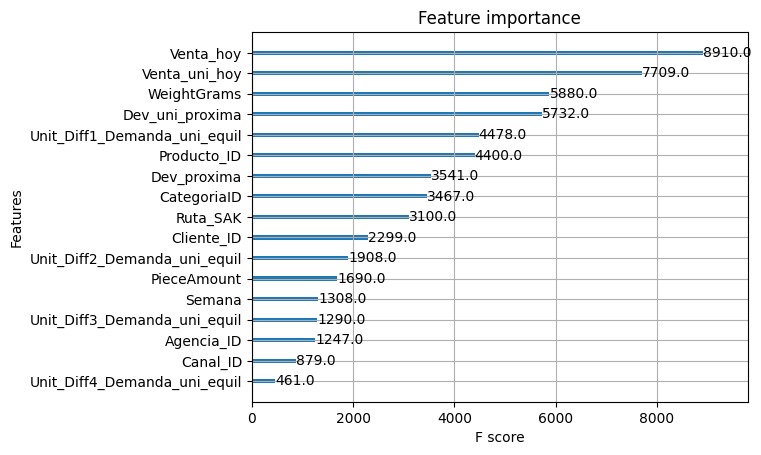

In [53]:
plot_importance(model)

### Best Label Encoding Model
Taking into account the RMSLE from the default parameters from the XGBoost library (0.04981518831476527) with the tuned model generated with Bayesian Optimization (0.04383476440102945), it was decided to use the Bayesian Optimization model with the following hyperparameters: <br><br>{'learning_rate': 0.08318015910069994,
 'max_depth': 9,
 'subsample': 0.8950364855178672,
 'colsample_bytree': 0.7265359903940505,
 'min_child_weight': 1,
 'objective': 'reg:squaredlogerror',
 'n_estimators': 1000,
 'verbosity': 0,
 'eval_metric': 'rmsle'}



## One Hot Encoding Model

### Read encoded data

In [4]:
def getEncodedData(path = 'data/train_encoded_aguascalientes.csv', week = 8):
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    X_train = df.drop(['Demanda_uni_equil'], axis=1).query(f'Semana < {week}')
    y_train = df[['Demanda_uni_equil', 'Semana']].query(f'Semana < {week}').drop('Semana', axis = 1)
    X_validate = df.drop(['Demanda_uni_equil'], axis=1).query(f'Semana == {week}')
    y_validate = df[['Demanda_uni_equil', 'Semana']].query(f'Semana == {week}').drop('Semana', axis = 1)
            
    return X_train, y_train, X_validate, y_validate

#### Retrieve the training and validation data 
Retrieve the training data from week 3 to 7 with the encoded data and the validation data from week 8.

In [6]:
encoded_X_train, encoded_y_train, encoded_X_validate, encoded_y_validate = getEncodedData()

### Default XGBoost library model 

In [7]:
normal_encoded_model = xg.XGBRegressor()
normal_encoded_model.fit(encoded_X_train, encoded_y_train, verbose=False)
normal_encoded_predictions = normal_encoded_model.predict(encoded_X_validate)
print(normal_encoded_predictions)
norm_rmsle_val = rmsle(encoded_y_validate['Demanda_uni_equil'], normal_encoded_predictions)

[  9.045404 138.62947   24.0057   ... 164.50287  270.3117   172.11064 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_8788\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)


In [17]:
norm_rmsle_val

C:\Users\buga_\AppData\Local\Temp\ipykernel_8788\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)


0.052479287440977886

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

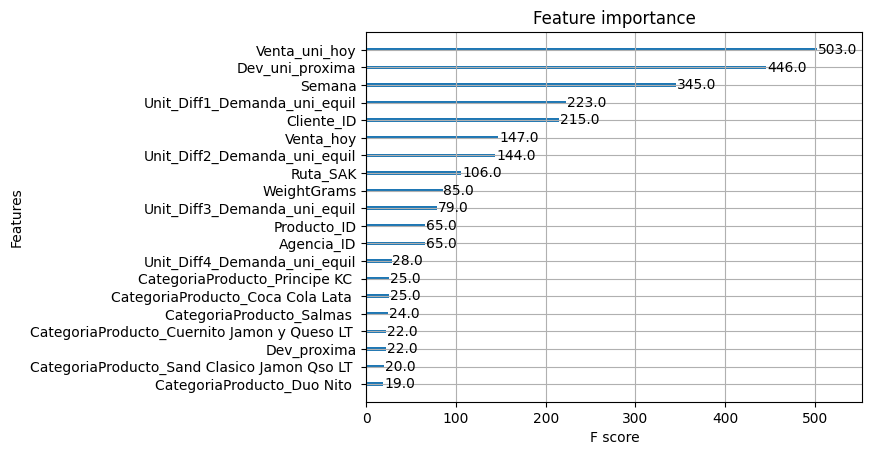

In [10]:
plot_importance(normal_encoded_model, max_num_features=20)

### Hyperparameter tuning with Bayesian Optimisation 

#### Bayesian Optimisation model tuning function 
The following code will suggest hyperparameter values for the One Hot Encoded model by implementing Bayesian Optimisation provided by Optuna.  

In [5]:
def encoded_objective(trial):
    params = {
        "objective": "reg:squaredlogerror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "eval_metric":"rmsle"
    }

    encoded_model = xg.XGBRegressor(**params)
    encoded_model.fit(encoded_X_train, encoded_y_train, verbose=False)
    encoded_predictions = encoded_model.predict(encoded_X_validate)
    print(encoded_predictions)
    rmsle_val = rmsle(encoded_y_validate['Demanda_uni_equil'], encoded_predictions)
    return rmsle_val

#### Parameter tuning execution

In [6]:
encoded_study = optuna.create_study(direction='minimize')
encoded_study.optimize(encoded_objective, n_trials=15)

[I 2023-12-02 17:33:38,743] A new study created in memory with name: no-name-57a7a8f6-4e8a-4b08-bc0f-0a109a83734d
[I 2023-12-02 18:01:43,661] Trial 0 finished with value: 0.969034316755401 and parameters: {'learning_rate': 0.00117917151529189, 'max_depth': 10, 'subsample': 0.7517211061849588, 'colsample_bytree': 0.2635565019497292, 'min_child_weight': 10}. Best is trial 0 with value: 0.969034316755401.


[1.957857  2.7270207 2.1585717 ... 2.7959065 2.7466254 2.7535152]


[I 2023-12-02 18:14:40,550] Trial 1 finished with value: 0.2845142244077225 and parameters: {'learning_rate': 0.006067190777326903, 'max_depth': 1, 'subsample': 0.1012382943627419, 'colsample_bytree': 0.9591141959782992, 'min_child_weight': 13}. Best is trial 1 with value: 0.2845142244077225.


[ 6.934325 21.835382 18.054249 ... 21.835382 21.226595 21.226595]


[I 2023-12-02 18:27:36,288] Trial 2 finished with value: 0.3001553997210857 and parameters: {'learning_rate': 0.0057669879119630315, 'max_depth': 1, 'subsample': 0.9930954211176073, 'colsample_bytree': 0.9647308364774378, 'min_child_weight': 3}. Best is trial 1 with value: 0.2845142244077225.


[ 6.80216  20.643917 17.54596  ... 20.643917 20.223255 20.223255]


[I 2023-12-02 18:55:34,290] Trial 3 finished with value: 0.9521759774203223 and parameters: {'learning_rate': 0.0011429570907602474, 'max_depth': 8, 'subsample': 0.8012005799069997, 'colsample_bytree': 0.5965789202840668, 'min_child_weight': 4}. Best is trial 1 with value: 0.2845142244077225.


[2.1438088 2.9784665 2.4655588 ... 2.966515  2.9449952 2.9391115]


[I 2023-12-02 19:13:01,083] Trial 4 finished with value: 0.08005052669974615 and parameters: {'learning_rate': 0.013552353130117888, 'max_depth': 4, 'subsample': 0.957576594289285, 'colsample_bytree': 0.6560726694725265, 'min_child_weight': 6}. Best is trial 4 with value: 0.08005052669974615.


[ 9.48296  84.76052  23.167458 ... 82.7923   81.64116  81.44588 ]


[I 2023-12-02 19:26:34,203] Trial 5 finished with value: 0.1345867833040565 and parameters: {'learning_rate': 0.07556891955534331, 'max_depth': 1, 'subsample': 0.5616713699636041, 'colsample_bytree': 0.7670933590607739, 'min_child_weight': 15}. Best is trial 4 with value: 0.08005052669974615.


[ 8.694753 55.038418 26.015089 ... 53.98559  52.44673  52.400272]


[I 2023-12-02 19:39:50,370] Trial 6 finished with value: 0.5011266221438524 and parameters: {'learning_rate': 0.010352275264182958, 'max_depth': 1, 'subsample': 0.7522075254560328, 'colsample_bytree': 0.05764941446524272, 'min_child_weight': 11}. Best is trial 4 with value: 0.08005052669974615.


[6.1124988 9.907664  6.3202934 ... 9.787759  7.6948805 7.6948805]


[I 2023-12-02 19:53:04,995] Trial 7 finished with value: 0.14304760599534128 and parameters: {'learning_rate': 0.060583604413779586, 'max_depth': 1, 'subsample': 0.3368958656150549, 'colsample_bytree': 0.7773738487800534, 'min_child_weight': 17}. Best is trial 4 with value: 0.08005052669974615.


[ 8.897351 48.025646 28.179567 ... 47.269222 45.743675 45.683647]


[I 2023-12-02 20:12:00,781] Trial 8 finished with value: 0.34131955392383906 and parameters: {'learning_rate': 0.003508455552368959, 'max_depth': 3, 'subsample': 0.753162943877262, 'colsample_bytree': 0.9592982780046038, 'min_child_weight': 13}. Best is trial 4 with value: 0.08005052669974615.


[ 6.529048 16.82976  12.805575 ... 16.841377 16.919207 16.919207]


[I 2023-12-02 20:30:12,884] Trial 9 finished with value: 0.6305635416137847 and parameters: {'learning_rate': 0.0031473978843495507, 'max_depth': 4, 'subsample': 0.7078149750563466, 'colsample_bytree': 0.14519391185176603, 'min_child_weight': 18}. Best is trial 4 with value: 0.08005052669974615.


[3.9622755 6.976576  4.5812564 ... 7.280933  6.7317185 6.7880206]


C:\Users\buga_\AppData\Local\Temp\ipykernel_24300\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 20:48:31,067] Trial 10 finished with value: 0.08005366313680864 and parameters: {'learning_rate': 0.02208875578942542, 'max_depth': 6, 'subsample': 0.995085060530563, 'colsample_bytree': 0.41776636215739854, 'min_child_weight': 7}. Best is trial 4 with value: 0.08005052669974615.


[ 9.371263 89.591545 21.722977 ... 88.19812  85.53927  85.42659 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_24300\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 21:07:53,460] Trial 11 finished with value: 0.08119631425750512 and parameters: {'learning_rate': 0.023047606363481635, 'max_depth': 6, 'subsample': 0.9118768512940018, 'colsample_bytree': 0.41025979042333227, 'min_child_weight': 7}. Best is trial 4 with value: 0.08005052669974615.


[ 9.290371 89.4099   20.933199 ... 85.73601  83.35371  83.27952 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_24300\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 21:26:48,548] Trial 12 finished with value: 0.07624214648341336 and parameters: {'learning_rate': 0.02275310204705169, 'max_depth': 6, 'subsample': 0.9996772950713025, 'colsample_bytree': 0.5013417545208972, 'min_child_weight': 7}. Best is trial 12 with value: 0.07624214648341336.


[ 9.369762 88.69995  22.04982  ... 88.21107  85.89884  85.90134 ]


[I 2023-12-02 21:43:43,575] Trial 13 finished with value: 0.05383437719667221 and parameters: {'learning_rate': 0.02315464804604368, 'max_depth': 4, 'subsample': 0.8948592337431164, 'colsample_bytree': 0.5642285853590672, 'min_child_weight': 1}. Best is trial 13 with value: 0.05383437719667221.


[  9.215645 119.10267   23.891075 ... 119.242584 117.420685 117.18209 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_24300\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)
[I 2023-12-02 22:02:48,114] Trial 14 finished with value: 0.049617921737961826 and parameters: {'learning_rate': 0.03207847929072769, 'max_depth': 8, 'subsample': 0.871186414052343, 'colsample_bytree': 0.4857620018298017, 'min_child_weight': 1}. Best is trial 14 with value: 0.049617921737961826.


[  9.22519  123.91732   24.208893 ... 125.38566  122.037895 121.88553 ]


#### Best model's parameters and RMSLE 

In [7]:
print('Best hyperparameters:', encoded_study.best_params)
print('Best RMSLE:', encoded_study.best_value)

Best hyperparameters: {'learning_rate': 0.03207847929072769, 'max_depth': 8, 'subsample': 0.871186414052343, 'colsample_bytree': 0.4857620018298017, 'min_child_weight': 1}
Best RMSLE: 0.049617921737961826


#### Hyperparameters' tuning best model 

In [11]:
encoded_params = getHyperparameters(encoded_study.best_params)
encoded_model = xg.XGBRegressor(**encoded_params)
""" encoded_model = xg.XGBRegressor(**{"objective": "reg:squaredlogerror","n_estimators": 1000,
        "verbosity": 0,'learning_rate': 0.03207847929072769, 'max_depth': 8, 'subsample': 0.871186414052343, 'colsample_bytree': 0.4857620018298017, 'min_child_weight': 1, "eval_metric":"rmsle"})"""
encoded_model.fit(encoded_X_train, encoded_y_train, verbose=False)
encoded_predictions = encoded_model.predict(encoded_X_validate)
print(encoded_predictions)
rmsle_val = rmsle(encoded_y_validate['Demanda_uni_equil'], encoded_predictions)

[  9.22519  123.91732   24.208893 ... 125.38566  122.037895 121.88553 ]


C:\Users\buga_\AppData\Local\Temp\ipykernel_8788\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)


In [12]:
rmsle_val

0.049617921737961826

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

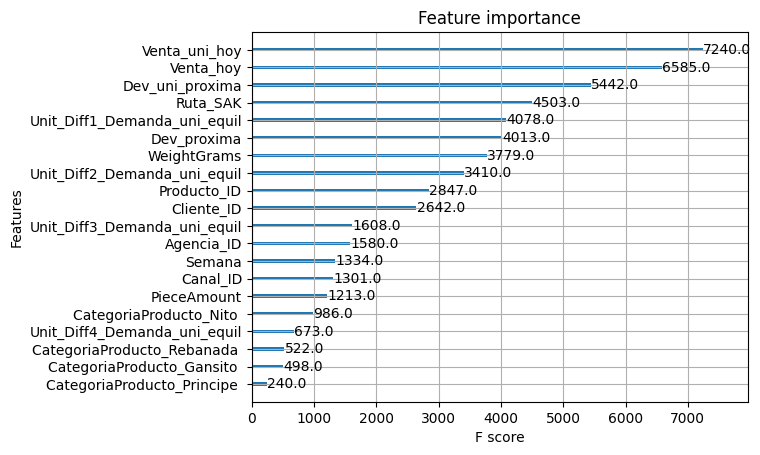

In [13]:
plot_importance(encoded_model, max_num_features=20)

#### Choosing best One Hot Encoded Model
After comparing the RMSLE of the default XGBoost model with 0.052479287440977886 and the best model from the Bayesian Optimisation tuning 0.049617921737961826, it was decided to implement the model with the following parameters: <br><br>
{'objective': 'reg:squaredlogerror',
 'n_estimators': 1000,
 'verbosity': 0,
 'learning_rate': 0.03207847929072769,
 'max_depth': 8,
 'subsample': 0.871186414052343,
 'colsample_bytree': 0.4857620018298017,
 'min_child_weight': 1,
 'eval_metric': 'rmsle'}


## Best Model Between Labeled Encoding and One Hot Encoding
After comparing the best model from both types of encoding, it was decided implement the Labeled Encoding model. One factor is that it has a lower RMSLE compared to the One Hot Encoding model. Secondly, the preprocessing of data required, time and computational consumption is less compared with the One Hot Encoding model.

In [22]:
params = {'learning_rate': 0.08318015910069994,
 'max_depth': 9,
 'subsample': 0.8950364855178672,
 'colsample_bytree': 0.7265359903940505,
 'min_child_weight': 1,
 'objective': 'reg:squaredlogerror',
 'n_estimators': 1000,
 'verbosity': 0,
 'eval_metric': 'rmsle'}
xg_model = xg.XGBRegressor(**params)
xg_model.fit(X_train, y_train['Demanda_uni_equil'], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7265359903940505, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08318015910069994,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

## 9 Week prediction 
To predict the 9th week, it will be necessary to use the predictions from the 8th week, modify the dataframe according with the results, adjust the 1 day shift for the 9th week to run afterwards the model and get the prediction.

### Function to get the dataframe to be filled 

In [47]:
def getPredictData(path = 'data/train_aguascalientes.csv', week = 8): 
    df = pd.DataFrame()
    
    for chunk in pd.read_csv(path, chunksize=100000):
        df = pd.concat([df, chunk])
        
    df['Demanda_uni_equil'] = np.where(df['Semana'] >= week, 0, df['Demanda_uni_equil'])
    df['Unit_Diff1_Demanda_uni_equil'] = np.where(df['Semana'] == week + 1, 0, df['Unit_Diff1_Demanda_uni_equil'])
            
    return df

### Function to predict demand using the created model and specifying the week to predict

In [151]:
def predictDemand(model, week, df): 
    X_train, y_train, X_predict, y_test = getTrainData(week=week)
    X_predict = df.drop(['Demanda_uni_equil', 'CategoriaProducto'], axis=1).query(f'Semana == {week}')
    predictions = model.predict(X_predict)
    pred_rmsle = rmsle(y_test['Demanda_uni_equil'], predictions)
    
    df_compare = pd.DataFrame({'Real': y_test['Demanda_uni_equil'][0:50], 'Predict': predictions[:50]})
    plt.plot(df_compare)
    plt.legend(['Real', 'Predict'])
    plt.title(f'Predictions for week {week}')
    return predictions, pred_rmsle

#### Function to return the updated df with the difference of 'Demanda_uni_equil'

In [127]:
def getDifferencedDemand(df): 
    demand_pivot = df.pivot_table(index=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], values='Demanda_uni_equil', aggfunc='sum')
    demand_pivot[f'Unit_Diff1_Demanda_uni_equil'] = demand_pivot.groupby(['Producto_ID', 'Agencia_ID','Cliente_ID'])['Demanda_uni_equil'].diff(periods=1)
    
    n_week_df = df.query('Semana == 9').drop('Unit_Diff1_Demanda_uni_equil', axis = 1)
    
    diff_df = n_week_df.merge(demand_pivot.drop(['Demanda_uni_equil'], axis=1), on=['Semana', 'Cliente_ID', 'Producto_ID', 'Agencia_ID'], how='left')
    
    diff_df.fillna(0, inplace=True)
    
    diff_df = pd.concat([df.query('Semana != 9'), diff_df], axis = 0)
    
    
    return diff_df

### Get the dataframe to use 

In [132]:
ags_df = getPredictData()

### Predict Demand for week 8

In [133]:
demand_prediction = predictDemand(xg_model, 8)
ags_df.loc[ags_df['Semana'] == 8, 'Demanda_uni_equil'] = demand_prediction[0].astype(int)

#### Get the updated Demanda_uni_equil df shifted by one for the 9th week

In [134]:
ags_df = getDifferencedDemand(ags_df)

#### Predict the values for the 9th week

C:\Users\buga_\AppData\Local\Temp\ipykernel_8788\4195201826.py:3: RuntimeWarning: invalid value encountered in log1p
  log_y_pred = np.log1p(y_pred)


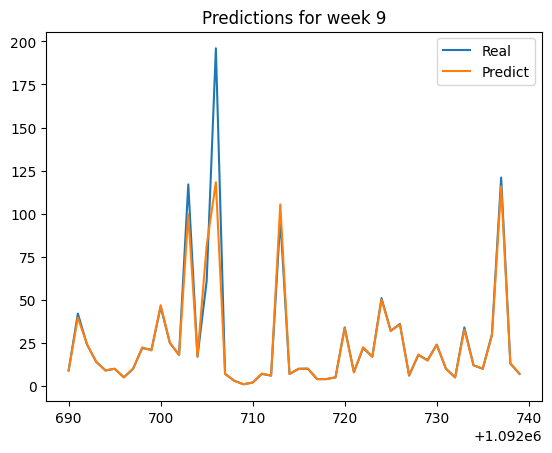

In [152]:
demand_prediction = predictDemand(xg_model, 9, ags_df)
ags_df.loc[ags_df['Semana'] == 9, 'Demanda_uni_equil'] = demand_prediction[0].astype(int)


In [ ]:
params = {'learning_rate': 0.08318015910069994,
 'max_depth': 9,
 'subsample': 0.8950364855178672,
 'colsample_bytree': 0.7265359903940505,
 'min_child_weight': 1,
 'objective': 'reg:squaredlogerror',
 'n_estimators': 1000,
 'verbosity': 0,
 'eval_metric': 'rmsle'}
xg_model = xg.XGBRegressor(**params)
xg_model.fit(X_train, y_train['Demanda_uni_equil'], verbose=False)
predictions = xg_model.predict(X_validate)
rmsle(y_validate['Demanda_uni_equil'], predictions)

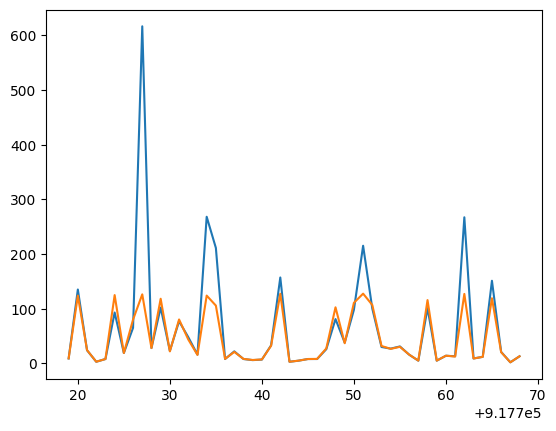

In [40]:
df_compare = pd.DataFrame({'Real': encoded_y_validate['Demanda_uni_equil'][:50], 'Predict': encoded_predictions[:50]})
plt.plot(df_compare)

In [20]:
rmsle_val

0.29213143289255605

In [12]:
rmsle(encoded_y_validate['Demanda_uni_equil'], predictions_encoded)

0.14048593554338254

In [ ]:
view = pd.DataFrame()
view['Real'] = y_validate['Demanda_uni_equil']
view['Pred'] = predictions

In [ ]:
X_train, y_train, X_validate, y_validate = getTrainData(week=9)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

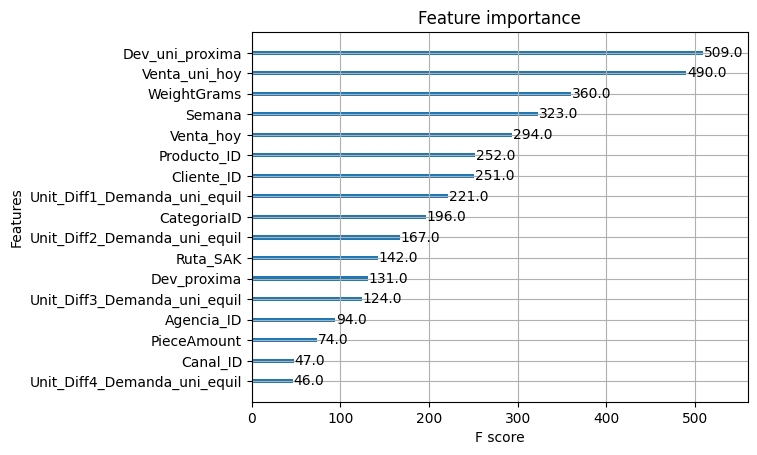

In [ ]:
plot_importance(model_encoded)

In [ ]:
X_train_Encode, y_train_Encode, X_validate_Encode, y_validate_Encode = getTrainData(path='data/train_encoded_aguascalientes.csv')

KeyError: "['CategoriaProducto'] not found in axis"

In [ ]:
xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

In [ ]:
xgb_r.fit(X_train, y_train['Demanda_uni_equil'])

c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
pred = xgb_r.predict(X_validate) 

In [ ]:
rmse = np.sqrt(MSE(y_validate['Demanda_uni_equil'], pred)) 
rmse

8.640892583240051

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

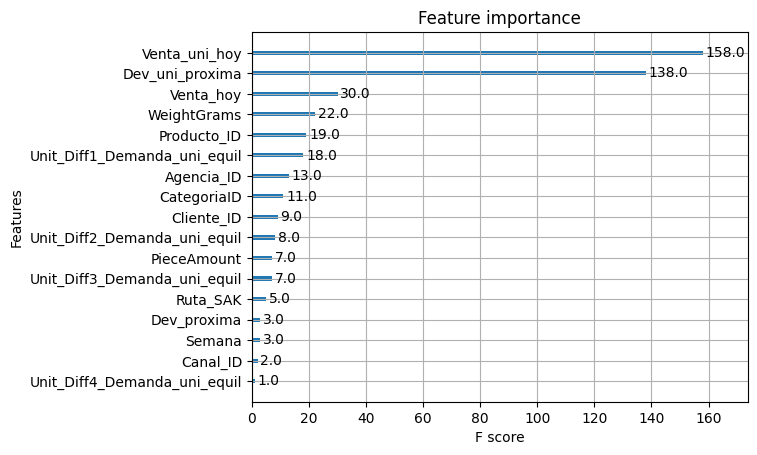

In [ ]:
plot_importance(xgb_r)

In [ ]:
y_validate['pred'] = pred

In [ ]:
y_validate.query('Demanda_uni_equil < 50 & Demanda_uni_equil > 40')

,Demanda_uni_equil,Semana,pred
917732,48,8,44.825722
919165,48,8,44.719360
919579,47,8,44.719360
920363,44,8,44.719360
920364,49,8,44.719360
...,...,...,...
1092532,43,8,43.925407
1092551,46,8,44.719360
1092561,49,8,44.719360
1092592,49,8,44.719360
